## Run Notebook Cells from VS Code

- To run the notebook programmatically: `python -m nbconvert --to notebook --execute notebooks/image_scores_analysis.ipynb --output notebooks/image_scores_analysis.output.ipynb`
- Or use `papermill` to parameterize and run: `papermill notebooks/image_scores_analysis.ipynb notebooks/image_scores_analysis.output.ipynb`
- In VS Code: use the interactive run cell controls or the Notebook UI; outputs appear in the Notebook Editor and integrated Output pane.

When committed, strip large outputs and keep `data/` directory out of repo.

In [64]:
# Section: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

sns.set(style="whitegrid")


In [65]:
# Read CSV

df = pd.read_csv('../data/image_scores.csv')


In [66]:
# Collapse paired stimulus rows (base + _frt) into one row per stimulus
# Strategy: create "stimulus" base name (remove trailing _frt),
# then take the first non-null value per column within each group.

# Ensure empty strings are treated as NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Create base stimulus id
df['stimulus'] = df['File Name'].astype(str).str.replace(r'_frt$', '', regex=True)

# Aggregation helper: first non-null value
def first_nonnull(s):
    s2 = s.dropna()
    return s2.iloc[0] if not s2.empty else np.nan

collapsed = df.groupby('stimulus', dropna=False).agg(first_nonnull).reset_index(drop=False)

# Set 'File Name' to the stimulus name and drop the temporary column
collapsed['File Name'] = collapsed['stimulus']
collapsed = collapsed.drop(columns=['stimulus'])

# Convert numeric-like columns to numbers where possible
for col in collapsed.columns:
    if col == 'File Name':
        continue
    # attempt to coerce to numeric; preserve if not numeric
    try:
        collapsed[col] = pd.to_numeric(collapsed[col])
    except (ValueError, TypeError):
        pass  # keep as is if not numeric

# Rename column for better readability
collapsed = collapsed.rename(columns={'CognitiveDemand': 'Cognitive Demand'})

# Remove 'Engagement' column and rename 'EngagementFRT' to 'Engagement'
if 'Engagement' in collapsed.columns:
    collapsed = collapsed.drop(columns=['Engagement'])
collapsed = collapsed.rename(columns={'EngagementFRT': 'Engagement'})

# Add `Type` column based on File Name prefix
# - filenames starting with 'C' -> 'Confectionary'
# - filenames starting with 'HG' -> 'Household Goods'
# treat other/unknown prefixes as NaN
def classify_type(fname):
    if not isinstance(fname, str):
        return np.nan
    if fname.startswith('C'):
        return 'Confectionary'
    if fname.startswith('HG'):
        return 'Household Goods'
    return np.nan

collapsed['Category'] = collapsed['File Name'].astype(str).apply(classify_type)

# Remove the old 'Type' column if it exists
if 'Type' in collapsed.columns:
    collapsed = collapsed.drop(columns=['Type'])

# Show results
print('Original rows:', len(df))
print('Collapsed rows (one per stimulus):', len(collapsed))
display(collapsed.head())

# NOTE: per your instruction, do not save outputs in this run.
# When you're ready to save the cleaned CSV, uncomment and run the lines below:
# out_path = Path('cleaned_image_scores.csv')
# collapsed.to_csv(out_path, index=False)
# print('Saved cleaned CSV to', out_path.resolve())

# Replace df with collapsed for subsequent cells
df = collapsed


Original rows: 58
Collapsed rows (one per stimulus): 29


,File Name,Cognitive Demand,Total Focus,Clarity,Start Focus,End Focus,Memory,Engagement,Category
0,C10,62.316664,57.349265,68.17,54.502368,29.419799,37.995636,55.177185,Confectionary
1,C11,70.059074,63.779903,69.60,61.720601,28.546610,54.532407,58.356891,Confectionary
2,C12,61.032063,49.333468,68.21,33.734610,20.208139,37.057805,57.064825,Confectionary
3,C13,68.038673,47.901010,64.42,44.658521,31.041710,66.003350,65.999350,Confectionary
4,C14,59.472052,59.683182,66.47,57.821495,35.158700,59.330350,65.082189,Confectionary


In [67]:
# Create histogram plots for each metric, colored by category
# Confectionary: deepskyblue, Household Goods: red

# Define the metric columns (exclude File Name and category)
metric_cols = [col for col in df.columns if col not in ['File Name', 'category']]

# Custom palette
palette = {'Confectionary': 'deepskyblue', 'Household Goods': 'red'}

# Create histograms for each metric
for col in metric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, hue='category', palette=palette, alpha=0.7, bins=20)
    plt.title(f'Distribution of {col} by Type')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


ValueError: Could not interpret value `category` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

Statistical Comparison: Confectionary vs Household Goods


C:\Users\ashra\AppData\Local\Temp\ipykernel_57560\3404509489.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=col, palette=palette)


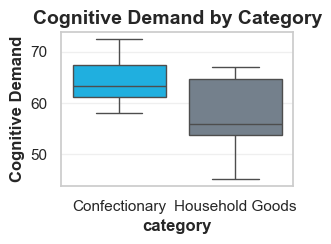

Cognitive Demand:
  Confectionary: n=14, mean=64.22, std=4.21
  Household Goods: n=15, mean=58.09, std=7.30
  t-statistic: 2.789, p-value: 0.0105
  → Significant difference (p < 0.05)



C:\Users\ashra\AppData\Local\Temp\ipykernel_57560\3404509489.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=col, palette=palette)


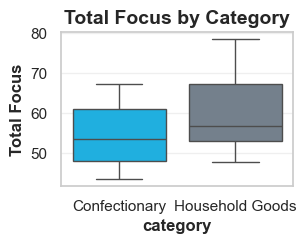

Total Focus:
  Confectionary: n=14, mean=54.31, std=8.11
  Household Goods: n=15, mean=60.06, std=9.26
  t-statistic: -1.783, p-value: 0.0859
  → No significant difference (p >= 0.05)



C:\Users\ashra\AppData\Local\Temp\ipykernel_57560\3404509489.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=col, palette=palette)


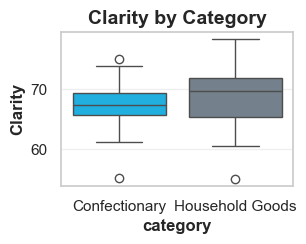

Clarity:
  Confectionary: n=14, mean=67.16, std=5.02
  Household Goods: n=15, mean=68.71, std=6.20
  t-statistic: -0.740, p-value: 0.4661
  → No significant difference (p >= 0.05)



C:\Users\ashra\AppData\Local\Temp\ipykernel_57560\3404509489.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=col, palette=palette)


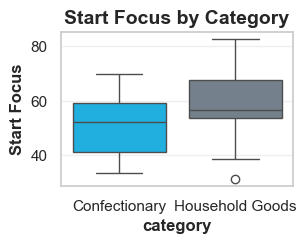

Start Focus:
  Confectionary: n=14, mean=50.41, std=11.52
  Household Goods: n=15, mean=59.11, std=14.28
  t-statistic: -1.812, p-value: 0.0814
  → No significant difference (p >= 0.05)



C:\Users\ashra\AppData\Local\Temp\ipykernel_57560\3404509489.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=col, palette=palette)


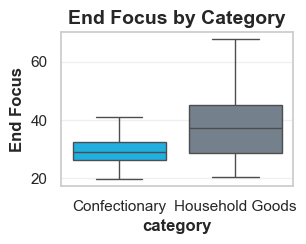

End Focus:
  Confectionary: n=14, mean=29.11, std=6.00
  Household Goods: n=15, mean=38.96, std=13.33
  t-statistic: -2.591, p-value: 0.0176
  → Significant difference (p < 0.05)



C:\Users\ashra\AppData\Local\Temp\ipykernel_57560\3404509489.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=col, palette=palette)


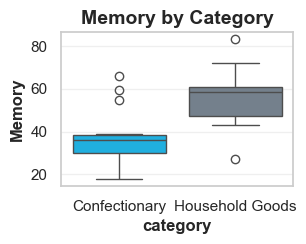

Memory:
  Confectionary: n=14, mean=38.04, std=13.40
  Household Goods: n=15, mean=55.08, std=13.15
  t-statistic: -3.452, p-value: 0.0019
  → Significant difference (p < 0.05)



C:\Users\ashra\AppData\Local\Temp\ipykernel_57560\3404509489.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=col, palette=palette)


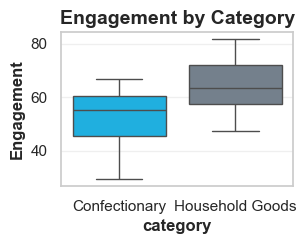

Engagement:
  Confectionary: n=14, mean=52.61, std=11.88
  Household Goods: n=15, mean=63.90, std=9.73
  t-statistic: -2.788, p-value: 0.0099
  → Significant difference (p < 0.05)



In [ ]:
# Create boxplots for each metric by Type and calculate p-values
# Confectionary: deepskyblue, Household Goods: red

import scipy.stats as stats

# Define the metric columns (exclude File Name and category)
metric_cols = [col for col in df.columns if col not in ['File Name', 'category']]

# Custom palette
palette = {'Confectionary': 'deepskyblue', 'Household Goods': 'slategrey'}

print("Statistical Comparison: Confectionary vs Household Goods")
print("=" * 60)

# Create boxplots and calculate p-values for each metric
for col in metric_cols:
    # Create boxplot
    plt.figure(figsize=(3, 2))  # Smaller figure size
    sns.boxplot(data=df, x='category', y=col, palette=palette)
    plt.title(f'{col} by Category', fontsize=14)  # Bigger font
    plt.xlabel('category', fontsize=12)  # Bigger font
    plt.ylabel(col, fontsize=12)  # Bigger font
    plt.show()

    # Calculate p-value using t-test (assuming normal distributions)
    conf_data = df[df['category'] == 'Confectionary'][col].dropna()
    hg_data = df[df['category'] == 'Household Goods'][col].dropna()

    if len(conf_data) > 1 and len(hg_data) > 1:
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(conf_data, hg_data, equal_var=False)  # Welch's t-test

        print(f"{col}:")
        print(f"  Confectionary: n={len(conf_data)}, mean={conf_data.mean():.2f}, std={conf_data.std():.2f}")
        print(f"  Household Goods: n={len(hg_data)}, mean={hg_data.mean():.2f}, std={hg_data.std():.2f}")
        print(f"  t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
        if p_value < 0.05:
            print("  → Significant difference (p < 0.05)")
        else:
            print("  → No significant difference (p >= 0.05)")
        print()
    else:
        print(f"{col}: Insufficient data for statistical test")
        print()


In [69]:
# Identify the most dissimilar stimulus pairs between Confectionary and Household Goods
# Calculate average absolute difference across all metrics for each possible pair

import itertools

# Get the metric columns
metric_cols = [col for col in df.columns if col not in ['File Name', 'category']]

# Separate by type
conf_stimuli = df[df['category'] == 'Confectionary'][['File Name'] + metric_cols]
hg_stimuli = df[df['category'] == 'Household Goods'][['File Name'] + metric_cols]

# Calculate differences for all pairs
pair_differences = []

for conf_row, hg_row in itertools.product(conf_stimuli.iterrows(), hg_stimuli.iterrows()):
    conf_idx, conf_data = conf_row
    hg_idx, hg_data = hg_row

    # Calculate absolute differences for each metric
    differences = []
    for col in metric_cols:
        conf_val = conf_data[col]
        hg_val = hg_data[col]
        if pd.notna(conf_val) and pd.notna(hg_val):
            diff = abs(conf_val - hg_val)
            differences.append(diff)

    if differences:  # Only if we have valid differences
        avg_diff = np.mean(differences)
        pair_differences.append({
            'Confectionary': conf_data['File Name'],
            'Household Goods': hg_data['File Name'],
            'Avg_Abs_Difference': avg_diff,
            'Num_Metrics': len(differences)
        })

# Sort by average difference (descending)
pair_differences.sort(key=lambda x: x['Avg_Abs_Difference'], reverse=True)

# Display top 2 most dissimilar pairs
print("Top 2 Most Dissimilar Stimulus Pairs")
print("=" * 50)
for i, pair in enumerate(pair_differences[:2], 1):
    print(f"{i}. {pair['Confectionary']} vs {pair['Household Goods']}")
    print(f"   Average absolute difference: {pair['Avg_Abs_Difference']:.2f}")
    print(f"   Based on {pair['Num_Metrics']} metrics")
    print()

# Also show the least dissimilar pair for comparison
if pair_differences:
    least = pair_differences[-1]
    print("Least Dissimilar Pair (for comparison):")
    print(f"{least['Confectionary']} vs {least['Household Goods']}")
    print(f"   Average absolute difference: {least['Avg_Abs_Difference']:.2f}")
    print(f"   Based on {least['Num_Metrics']} metrics")

print("\n" + "=" * 60)
print("Most Dissimilar Pairs Per Metric")
print("=" * 60)

# Calculate most dissimilar pair for each metric
for col in metric_cols:
    max_diff = 0
    max_pair = None
    
    for conf_row, hg_row in itertools.product(conf_stimuli.iterrows(), hg_stimuli.iterrows()):
        conf_idx, conf_data = conf_row
        hg_idx, hg_data = hg_row
        
        conf_val = conf_data[col]
        hg_val = hg_data[col]
        
        if pd.notna(conf_val) and pd.notna(hg_val):
            diff = abs(conf_val - hg_val)
            if diff > max_diff:
                max_diff = diff
                max_pair = {
                    'Confectionary': conf_data['File Name'],
                    'Household Goods': hg_data['File Name'],
                    'Difference': diff
                }
    
    if max_pair:
        print(f"\n{col}:")
        print(f"  Most dissimilar: {max_pair['Confectionary']} vs {max_pair['Household Goods']}")
        print(f"  Absolute difference: {max_pair['Difference']:.2f}")

KeyError: 'category'

In [ ]:
# For Confectionary stimuli, show highest and lowest scoring stimuli per metric

# Filter to Confectionary only
conf_df = df[df['category'] == 'Confectionary']

print("Confectionary Stimuli: Highest and Lowest Scores Per Metric")
print("=" * 65)

for col in metric_cols:
    # Get non-null values for this metric
    valid_data = conf_df[['File Name', col]].dropna()
    
    if len(valid_data) >= 2:  # Need at least 2 values to show high/low
        # Find highest
        max_row = valid_data.loc[valid_data[col].idxmax()]
        # Find lowest  
        min_row = valid_data.loc[valid_data[col].idxmin()]
        
        print(f"\n{col}:")
        print(f"  Highest: {max_row['File Name']} ({max_row[col]:.2f})")
        print(f"  Lowest:  {min_row['File Name']} ({min_row[col]:.2f})")
        print(f"  Range:   {max_row[col] - min_row[col]:.2f}")
    else:
        print(f"\n{col}: Insufficient data")

print(f"\nTotal Confectionary stimuli analyzed: {len(conf_df)}")

Confectionary Stimuli: Highest and Lowest Scores Per Metric

Cognitive Demand:
  Highest: C7 (72.44)
  Lowest:  C8 (57.96)
  Range:   14.48

Total Focus:
  Highest: C4 (67.24)
  Lowest:  C8 (43.52)
  Range:   23.71

Clarity:
  Highest: C2 (74.96)
  Lowest:  C4 (55.31)
  Range:   19.65

Start Focus:
  Highest: C3 (69.73)
  Lowest:  C6 (33.63)
  Range:   36.10

End Focus:
  Highest: C7 (40.92)
  Lowest:  C6 (19.71)
  Range:   21.21

Memory:
  Highest: C13 (66.00)
  Lowest:  C2 (17.75)
  Range:   48.25

Engagement:
  Highest: C2 (66.61)
  Lowest:  C6 (29.37)
  Range:   37.23

Total Confectionary stimuli analyzed: 14


In [68]:
df.to_csv('cleaned_image_scores.csv', index=False)